In [ ]:
# %reset

## 패키지

In [ ]:
!pip install pymysql
!sudo apt-get install -y fonts-nanum # 나눔 폰트 설치 (설치 후 런타임 재시작하고 코드 실행)
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [ ]:
import numpy as np
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import shapiro , normaltest
font_name = fm.FontProperties().get_name()
plt.rc('font', family=font_name) # 한글 출력

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 로드

In [ ]:
# DB 연결
endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema_name = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema_name )
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

In [ ]:
def sql_to_df(table_name):
    sql = "SELECT * FROM {}".format(table_name)
    df = pd.read_sql(sql, db_connection)
    return df

In [ ]:
df = sql_to_df('MainData_차선수_이산형_이용빈도추가')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                497 non-null    int64  
 1   위도                497 non-null    float64
 2   경도                497 non-null    float64
 3   생태통로_유형           497 non-null    int64  
 4   등산객_이용빈도          497 non-null    int64  
 5   생태통로_효율성          497 non-null    int64  
 6   이용확인종_수           497 non-null    int64  
 7   폭(m)              309 non-null    float64
 8   연장(m)             309 non-null    float64
 9   높이(m)             44 non-null     float64
 10  개방도               44 non-null     float64
 11  경사도               497 non-null    object 
 12  주변 로드킬 빈도         497 non-null    int64  
 13  산책로까지의 최단 거리(km)  497 non-null    float64
 14  농가까지의 거리(km)      497 non-null    float64
 15  도로 최고제한속도(km/h)   497 non-null    int64  
 16  지형기호(2.3km)       497 non-null    object 
 1

### 사용하지 않는 열 삭제

In [ ]:
df.drop(['최우점식물군락', '주변 로드킬 빈도'], axis=1, inplace=True)

## 식생, 지형 내용 변경

In [ ]:
df['식물군락명'] = [0 if ((not '나무' in x) | (not '군락' in x)) else x for x in df['식물군락명']]
df['식물군락명'] = [1 if x!=0 else x for x in df['식물군락명']]
df['식물군락명'].unique()

array([1, 0])

In [ ]:
df['지형기호(2.3km)'] = [x.split('-')[0] for x in df['지형기호(2.3km)']]
df['지형기호(2.3km)'].unique()

array(['X', '하천', '산지', '기타', '해안', '화산'], dtype=object)

In [ ]:
df.rename(columns={'식물군락명':'식생'}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                497 non-null    int64  
 1   위도                497 non-null    float64
 2   경도                497 non-null    float64
 3   생태통로_유형           497 non-null    int64  
 4   등산객_이용빈도          497 non-null    int64  
 5   생태통로_효율성          497 non-null    int64  
 6   이용확인종_수           497 non-null    int64  
 7   폭(m)              309 non-null    float64
 8   연장(m)             309 non-null    float64
 9   높이(m)             44 non-null     float64
 10  개방도               44 non-null     float64
 11  경사도               497 non-null    object 
 12  산책로까지의 최단 거리(km)  497 non-null    float64
 13  농가까지의 거리(km)      497 non-null    float64
 14  도로 최고제한속도(km/h)   497 non-null    int64  
 15  지형기호(2.3km)       497 non-null    object 
 16  하천거리(km)          497 non-null    float64
 1

# Split 육교형/터널형

In [ ]:
df_overpass = df[df['생태통로_유형'] == 0] # 육교형
df_tunnel = df[df['생태통로_유형'] != 0] # 터널형
df_overpass.drop(['개방도', '높이(m)'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# index 초기화
df_overpass.reset_index(drop = True,inplace= True)
df_tunnel.reset_index(drop = True,inplace= True)

In [ ]:
# 육교형 생태통로 MainData DF 정보
df_overpass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 496
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                300 non-null    int64  
 1   위도                300 non-null    float64
 2   경도                300 non-null    float64
 3   생태통로_유형           300 non-null    int64  
 4   등산객_이용빈도          300 non-null    int64  
 5   생태통로_효율성          300 non-null    int64  
 6   이용확인종_수           300 non-null    int64  
 7   폭(m)              264 non-null    float64
 8   연장(m)             264 non-null    float64
 9   경사도               300 non-null    object 
 10  산책로까지의 최단 거리(km)  300 non-null    float64
 11  농가까지의 거리(km)      300 non-null    float64
 12  도로 최고제한속도(km/h)   300 non-null    int64  
 13  지형기호(2.3km)       300 non-null    object 
 14  하천거리(km)          300 non-null    float64
 15  식생                300 non-null    int64  
 16  등산로까지 최단거리(km)    300 non-null    float64
 1

In [ ]:
# 터널형 생태통로 MainData DF 정보
df_tunnel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 1 to 477
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                197 non-null    int64  
 1   위도                197 non-null    float64
 2   경도                197 non-null    float64
 3   생태통로_유형           197 non-null    int64  
 4   등산객_이용빈도          197 non-null    int64  
 5   생태통로_효율성          197 non-null    int64  
 6   이용확인종_수           197 non-null    int64  
 7   폭(m)              45 non-null     float64
 8   연장(m)             45 non-null     float64
 9   높이(m)             43 non-null     float64
 10  개방도               43 non-null     float64
 11  경사도               197 non-null    object 
 12  산책로까지의 최단 거리(km)  197 non-null    float64
 13  농가까지의 거리(km)      197 non-null    float64
 14  도로 최고제한속도(km/h)   197 non-null    int64  
 15  지형기호(2.3km)       197 non-null    object 
 16  하천거리(km)          197 non-null    float64
 1

# 이상치

## 이상치 확인

In [ ]:
# 이상치 처리해야 할 컬럼 목록
overpass_check = ['차선_수', '이용확인종_수', '폭(m)', '연장(m)', '산책로까지의 최단 거리(km)',
                  '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '주변 동물종 개수', '주변동물 출현빈도', '하천거리(km)', 
                  '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']

tunnel_check = ['차선_수', '이용확인종_수', '폭(m)', '연장(m)', '높이(m)', '개방도',
                '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '주변 동물종 개수', '주변동물 출현빈도', 
                '하천거리(km)', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']

print(len(overpass_check))
print(len(tunnel_check))

15
17


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_

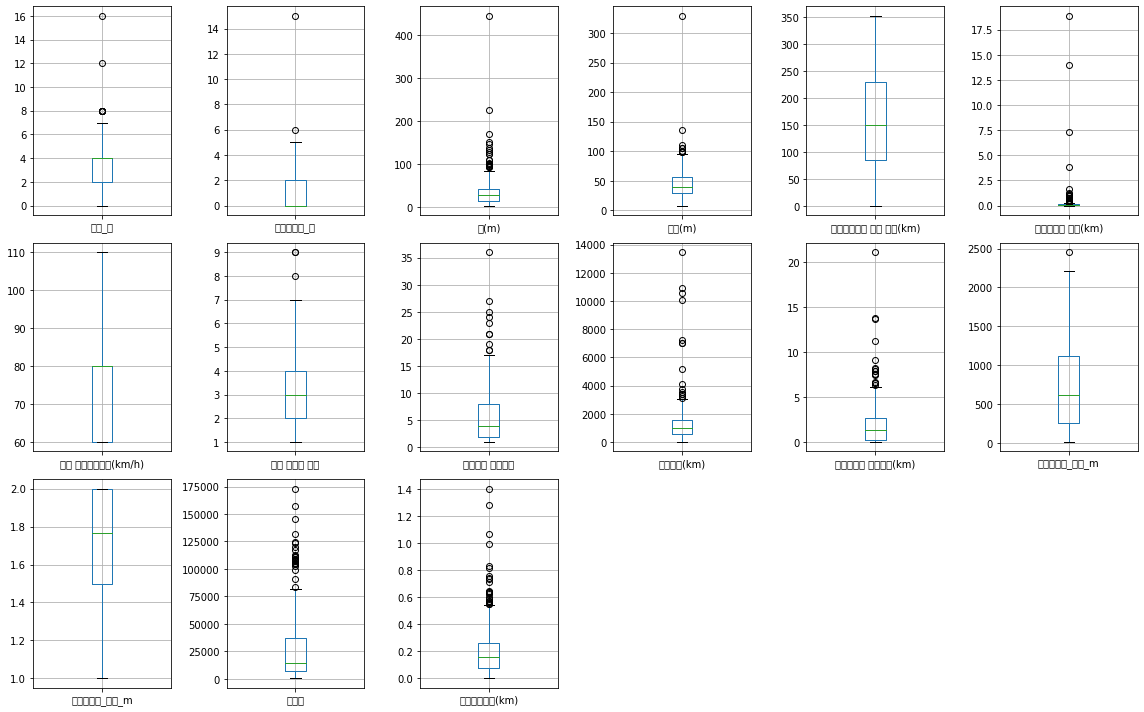

In [ ]:
# 육교형 생태통로 Boxplot
plt.figure(figsize=(16, 10))

for i, col in enumerate(overpass_check):
  plt.subplot(3, 6, i+1)
  df_overpass.boxplot(col)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_

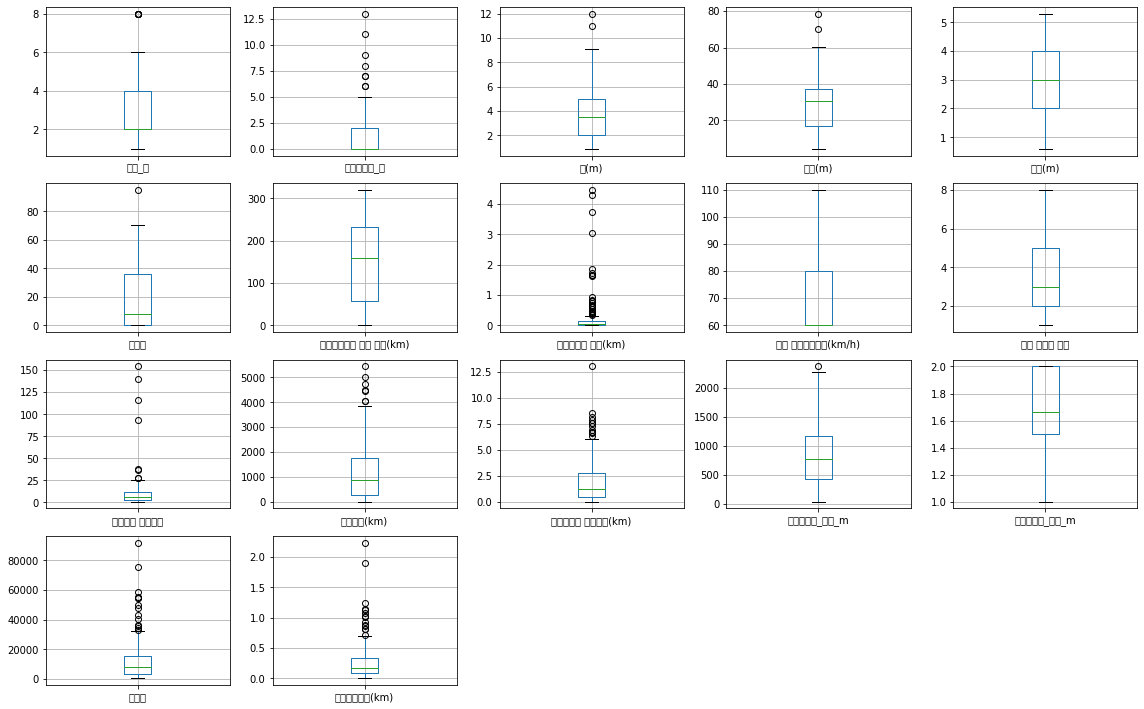

In [ ]:
# 터널형 생태통로 Boxplot
plt.figure(figsize=(16, 10))

for i, col in enumerate(tunnel_check):
  plt.subplot(4, 5, i+1)
  df_tunnel.boxplot(col)

plt.tight_layout()
plt.show()

## 이상치 처리

tukey fence 방식으로 처리

In [ ]:
# 높은 이상치는 Boxplot의 상한값으로, 낮은 이상치는 Boxplot의 하한값으로 대체하는 함수
def change_outlier(df, col_list):
  for col_name in col_list:
      Q1 = df[col_name].quantile(q=0.25)
      Q3 = df[col_name].quantile(q=0.75)
      IQR = Q3-Q1

      print('[' + col_name + ']', end=' ')
      high_idx = df[df[col_name] > (Q3+1.5*IQR)].index
      df.loc[high_idx, col_name] = round(Q3+1.5*IQR, 1)
      print(str(len(high_idx)) +'개가 상한값으로 변경됨', end=' / ')

      low_idx = df[df[col_name] < (Q1-1.5*IQR)].index
      df.loc[low_idx, col_name] = round(Q1-1.5*IQR, 1)
      print(str(len(low_idx)) +'개가 하한값으로 변경됨')

  return df

In [ ]:
# 육교형 이상치 처리
df_overpass = change_outlier(df_overpass, overpass_check)

[차선_수] 8개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[이용확인종_수] 2개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[폭(m)] 21개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[연장(m)] 9개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[산책로까지의 최단 거리(km)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[농가까지의 거리(km)] 26개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[도로 최고제한속도(km/h)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변 동물종 개수] 3개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변동물 출현빈도] 10개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[하천거리(km)] 15개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[등산로까지 최단거리(km)] 16개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_연장_m] 1개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_높이_m] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[교통량] 29개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[건물까지거리(km)] 23개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
# 터널형 이상치 처리
df_tunnel = change_outlier(df_tunnel, tunnel_check) 

[차선_수] 5개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[이용확인종_수] 8개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[폭(m)] 2개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[연장(m)] 2개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[높이(m)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[개방도] 1개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[산책로까지의 최단 거리(km)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[농가까지의 거리(km)] 27개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[도로 최고제한속도(km/h)] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변 동물종 개수] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[주변동물 출현빈도] 8개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[하천거리(km)] 7개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[등산로까지 최단거리(km)] 12개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_연장_m] 1개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[유도울타리_높이_m] 0개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[교통량] 14개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨
[건물까지거리(km)] 14개가 상한값으로 변경됨 / 0개가 하한값으로 변경됨


In [ ]:
# 이상치 처리된 MainData DF → DB로 업로드
# df_overpass.to_sql(name='MainData_outlier_overpass', con=db_connection, if_exists='replace', index=False)
# df_tunnel.to_sql(name='MainData_outlier_tunnel', con=db_connection, if_exists='replace', index=False)

# 범주형 변수 원핫인코딩

In [ ]:
cat_col = ['등산객_이용빈도', '경사도', '환경영향평가점수', '지형기호(2.3km)']
df_overpass = pd.get_dummies(data=df_overpass, columns=cat_col)
df_tunnel = pd.get_dummies(data=df_tunnel, columns=cat_col)

# 결측치 처리

In [ ]:
# 유도울타리 높이, 연장, 주변동물 출현빈도, 주변 동물종 개수 => 존재하지 않는 것이므로 0으로 처리
df_overpass[['유도울타리_높이_m', '유도울타리_연장_m', '주변동물 출현빈도', '주변 동물종 개수']] = df_overpass[['유도울타리_높이_m', '유도울타리_연장_m', '주변동물 출현빈도', '주변 동물종 개수']].fillna(0)
df_tunnel[['유도울타리_높이_m', '유도울타리_연장_m', '주변동물 출현빈도', '주변 동물종 개수']] = df_tunnel[['유도울타리_높이_m', '유도울타리_연장_m', '주변동물 출현빈도', '주변 동물종 개수']].fillna(0)

## Case 1. 평균으로 대체

In [ ]:
# 규격 데이터의 결측치를 평균으로 대치하는 함수(평균)
def MeanImputation(df, col_list):
  df_copy = df.copy()
  for col_name in col_list:
    df_copy[col_name].fillna(df_copy[col_name].mean(), inplace=True)
  return df_copy

## Case 2. KNN으로 대체

In [ ]:
# KNN 알고리즘으로 결측값 대체 함수
def KNNImputation(df, n_neighbors):
  df_copy = df.copy()
  col = df_copy.columns
  imputer = KNNImputer(n_neighbors=n_neighbors)
  df_imputed = imputer.fit_transform(df_copy)
  df_copy = pd.DataFrame(df_imputed)
  return df_copy, col

## 처리 수행

In [ ]:
# [Case 1] 평균으로 대체
df_overpass_mean = MeanImputation(df_overpass, ['폭(m)', '연장(m)', '교통량']) # 육교형
df_tunnel_mean = MeanImputation(df_tunnel, ['폭(m)', '연장(m)', '높이(m)', '개방도', '교통량']) # 터널형

In [ ]:
# [Case 2] KNN으로 대체
drop_col = ['번호', '위도', '경도', '생태통로_효율성', '유도울타리_위도_2.3km', '유도울타리_경도_2.3km', '일평균이용빈도', '생태통로_유형']
for i in range(1, 6, 2):
  # 육교형
  df_over, col_over = KNNImputation(df_overpass.drop(drop_col, axis=1, inplace=False), i)
  df_over.columns = col_over
  globals()['df_overpass_knn{}'.format(i)] = pd.concat([df_overpass['일평균이용빈도'],df_over], axis = 1)

  # 터널형
  df_tun, col_tun = KNNImputation(df_tunnel.drop(drop_col, axis=1, inplace=False), i)
  df_tun.columns = col_tun
  globals()['df_tunnel_knn{}'.format(i)] = pd.concat([df_tunnel['일평균이용빈도'],df_tun], axis = 1)

# 스케일링
- 정규화 or 표준화 선택 
  - 조건수(Condition No.) 보고 더 낮게 나오는 것으로 선택
  - 해당 데이터셋에서는 **정규화**가 더 낮게 나옴

In [ ]:
# 데이터 프레임 리스트
df_list = [df_overpass_mean, df_tunnel_mean, df_overpass_knn1, df_overpass_knn3, df_overpass_knn5, df_tunnel_knn1, df_tunnel_knn3, df_tunnel_knn5]

## 정규화

In [ ]:
# 정규화가 필요한 columns
scale_col = ['이용확인종_수','폭(m)', '연장(m)', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)', 
             '하천거리(km)','차선_수', '주변 동물종 개수','주변동물 출현빈도', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']

# MinMaxScaler
for df in df_list :
  scaler = MinMaxScaler()
  df[scale_col] = scaler.fit_transform(df[scale_col])

## 표준화

In [ ]:
# # 표준화가 필요한 columns
# scale_col = ['이용확인종_수','폭(m)', '연장(m)', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)', 
#              '하천거리(km)','차선_수', '주변 동물종 개수','주변동물 출현빈도', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']


# # StandardScaler
# for df in df_list :
#   scaler = StandardScaler()
#   df[scale_col] = scaler.fit_transform(df[scale_col])

# 정규성 확인 (생략)

In [ ]:
normal = []
notnormal = []
for df in df_list:
  for var in df.columns :
      stat, p  = shapiro(df[var].dropna().values)
      stat, p  = normaltest(df[var].dropna().values)
      alpha = 0.001
      if p > alpha :
          normal.append(var)
      else :
          notnormal.append(var)

In [ ]:
print(normal)
print(notnormal)

['차선_수', '차선_수', '차선_수', '차선_수', '폭(m)', '높이(m)', '폭(m)', '높이(m)']
['이용확인종_수', '폭(m)', '연장(m)', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '하천거리(km)', '식생', '등산로까지 최단거리(km)', '건물까지거리(km)', '교통량', '주변 동물종 개수', '주변동물 출현빈도', '유도울타리_연장_m', '유도울타리_높이_m', '일평균이용빈도', '등산객_이용빈도_0', '등산객_이용빈도_1', '등산객_이용빈도_2', '등산객_이용빈도_3', '등산객_이용빈도_4', '등산객_이용빈도_5', '경사도_0', '경사도_1', '경사도_2', '경사도_3', '경사도_4', '경사도_5', '경사도_6', '환경영향평가점수_1', '환경영향평가점수_2', '환경영향평가점수_3', '환경영향평가점수_4', '환경영향평가점수_5', '지형기호(2.3km)_X', '지형기호(2.3km)_기타', '지형기호(2.3km)_산지', '지형기호(2.3km)_하천', '지형기호(2.3km)_해안', '이용확인종_수', '폭(m)', '연장(m)', '높이(m)', '개방도', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '하천거리(km)', '식생', '등산로까지 최단거리(km)', '건물까지거리(km)', '차선_수', '교통량', '주변 동물종 개수', '주변동물 출현빈도', '유도울타리_연장_m', '유도울타리_높이_m', '일평균이용빈도', '등산객_이용빈도_0', '등산객_이용빈도_1', '등산객_이용빈도_2', '등산객_이용빈도_3', '등산객_이용빈도_4', '등산객_이용빈도_5', '경사도_0', '경사도_1', '경사도_2', '경사도_3', '경사도_4', '경사도_5', '경사도_6', '환경영향평가점수_1', '환경영향평가점수_2', '환경영향평가점수_3', '환경

# 변수 선택 및 다중공선성 확인 (VIF)

In [ ]:
df_400_list = [] # 일평균이용빈도 값이 없는 행만 있는 DF List
df_60_list = [] # 일평균이용빈도 값이 존재하는 행만 있는 DF List
for df in df_list:
  df_copy = df.copy()
  df_400_list.append(df_copy[df_copy['일평균이용빈도'].isna()])
  df_60_list.append(df_copy[df_copy['일평균이용빈도'].notna()])

In [ ]:
exp = df.drop('일평균이용빈도', axis=1) # 설명변수 DF
dep = df['일평균이용빈도'] # 종속변수 DF

In [ ]:
# 수치형 독립변수들에 대한 다중공선성 확인
def check_vif(num_X_df):
  vif = pd.DataFrame()
  vif["VIF Factor"] = [variance_inflation_factor(num_X_df.values, i) for i in range(num_X_df.shape[1])]
  vif["features"] = num_X_df.columns
  print(vif)

In [ ]:
def step_selection(df, exp, dep, newx): # 인수 : 원본 데이터프레임, 설명변수 데이터프레임, 종속변수 데이터프레임
  ## 전진 단계별 선택법
  variables = exp.columns.tolist() ## 설명 변수 리스트
  
  y = dep ## 반응 변수
  selected_variables = [] ## 선택된 변수들
  sl_enter = 0.2 # 0.05
  sl_remove = 0.2 # 0.05
  
  sv_per_step = [] ## 각 스텝별로 선택된 변수들
  adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
  steps = [] ## 스텝
  step = 0
  while len(variables) > 0:
      remainder = list(set(variables) - set(selected_variables))
      pval = pd.Series(index=remainder) ## 변수의 p-value
      ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
      ## 선형 모형을 적합한다.
      for col in remainder: 
          X = df[selected_variables+[col]]
          X = sm.add_constant(X)
          model = sm.OLS(y,X).fit()
          pval[col] = model.pvalues[col]
  
      min_pval = pval.min()
      if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
          selected_variables.append(pval.idxmin())
          ## 선택된 변수들에대해서
          ## 어떤 변수를 제거할지 고른다.
          while len(selected_variables) > 0:
              selected_X = df[selected_variables]
              selected_X = sm.add_constant(selected_X)
              selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
              max_pval = selected_pval.max()
              if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                  remove_variable = selected_pval.idxmax()
                  selected_variables.remove(remove_variable)
              else:
                  break
          
          step += 1
          steps.append(step)
          last_model = sm.OLS(y,sm.add_constant(df[selected_variables])).fit()
          adj_r_squared = last_model.rsquared_adj
          adjusted_r_squared.append(adj_r_squared)
          sv_per_step.append(selected_variables.copy())
      else:
          break

  # 최종 선택된 변수들 출력
  print('\nselected_variables:', selected_variables)

  print(last_model.summary()) # (추가)
  check_vif(df[selected_variables]) # 다중공선성 확인 (추가)

  # 단계별 모형 적합도 확인
  fig = plt.figure(figsize=(10,10))
  fig.set_facecolor('white')
  
  font_size = 15
  plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
  plt.plot(steps,adjusted_r_squared, marker='o')
      
  plt.ylabel('Adjusted R Squared',fontsize=font_size)
  plt.grid(True)
  plt.show()

  return selected_variables, last_model#,pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:14


selected_variables: ['등산객_이용빈도_3', '경사도_1', '식생', '건물까지거리(km)', '주변동물 출현빈도', '이용확인종_수', '농가까지의 거리(km)', '환경영향평가점수_3', '하천거리(km)']
                            OLS Regression Results                            
Dep. Variable:                일평균이용빈도   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     17.34
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           3.08e-09
Time:                        12:50:03   Log-Likelihood:                -52.768
No. Observations:                  38   AIC:                             125.5
Df Residuals:                      28   BIC:                             141.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44061 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0,

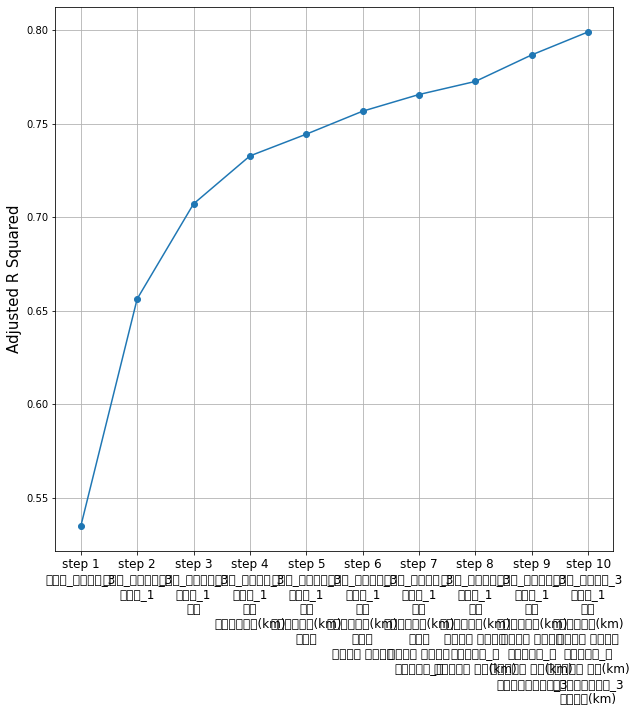

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:14


selected_variables: ['경사도_1', '개방도', '환경영향평가점수_5', '지형기호(2.3km)_산지', '경사도_6']
                            OLS Regression Results                            
Dep. Variable:                일평균이용빈도   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     12.43
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           4.82e-05
Time:                        12:50:06   Log-Likelihood:                0.32570
No. Observations:                  22   AIC:                             11.35
Df Residuals:                      16   BIC:                             17.89
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54872 missing from current font.
  font.set_

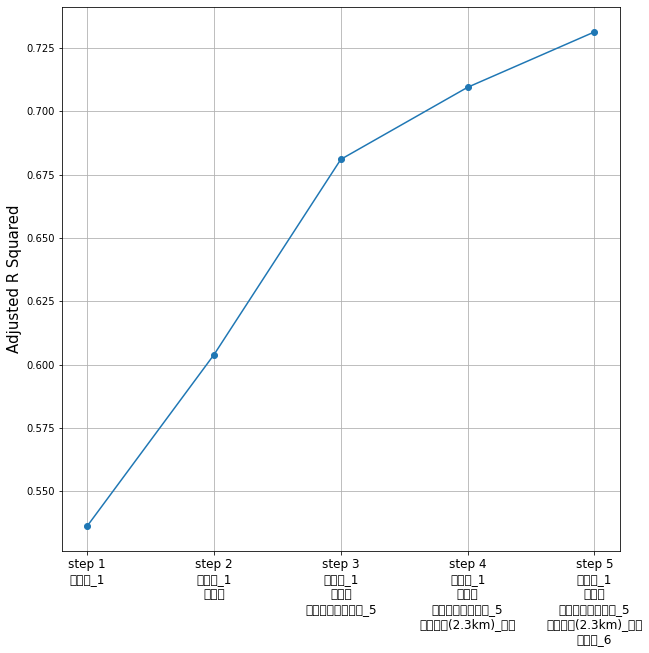

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:14


selected_variables: ['등산객_이용빈도_3', '교통량', '식생', '지형기호(2.3km)_산지', '주변동물 출현빈도', '등산로까지 최단거리(km)', '지형기호(2.3km)_해안', '경사도_0']
                            OLS Regression Results                            
Dep. Variable:                일평균이용빈도   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     17.92
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           4.03e-09
Time:                        12:50:10   Log-Likelihood:                -57.288
No. Observations:                  38   AIC:                             130.6
Df Residuals:                      30   BIC:                             143.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44061 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0,

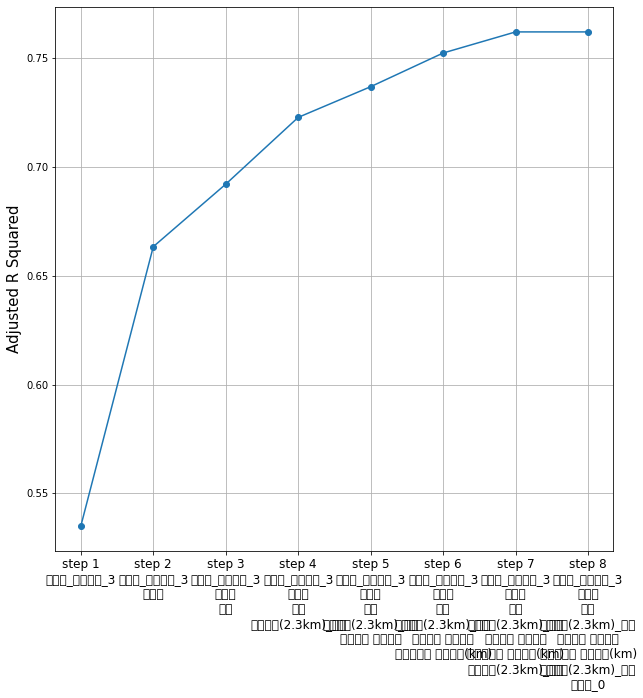

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:14


selected_variables: ['등산객_이용빈도_3', '교통량', '건물까지거리(km)', '주변동물 출현빈도', '이용확인종_수', '지형기호(2.3km)_하천']
                            OLS Regression Results                            
Dep. Variable:                일평균이용빈도   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     22.72
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           4.41e-10
Time:                        12:50:14   Log-Likelihood:                -56.510
No. Observations:                  38   AIC:                             127.0
Df Residuals:                      31   BIC:                             138.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_

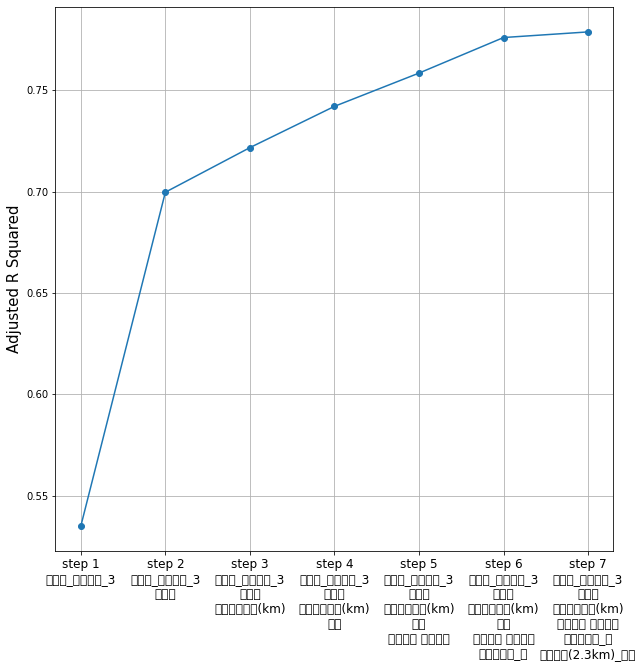

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:14


selected_variables: ['등산객_이용빈도_3', '교통량', '건물까지거리(km)', '폭(m)']
                            OLS Regression Results                            
Dep. Variable:                일평균이용빈도   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     29.36
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           1.87e-10
Time:                        12:50:18   Log-Likelihood:                -59.719
No. Observations:                  38   AIC:                             129.4
Df Residuals:                      33   BIC:                             137.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_

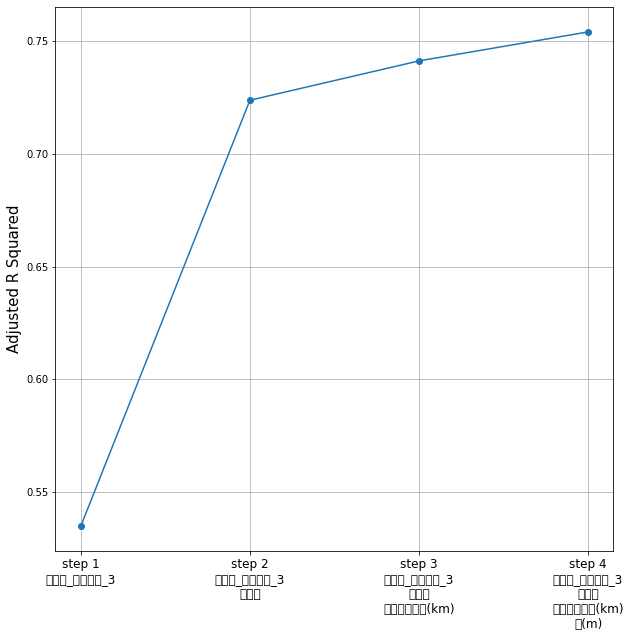

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:14


selected_variables: ['경사도_1', '하천거리(km)', '유도울타리_연장_m', '주변동물 출현빈도']
                            OLS Regression Results                            
Dep. Variable:                일평균이용빈도   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     12.17
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           7.48e-05
Time:                        12:50:22   Log-Likelihood:                -2.2558
No. Observations:                  22   AIC:                             14.51
Df Residuals:                      17   BIC:                             19.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_

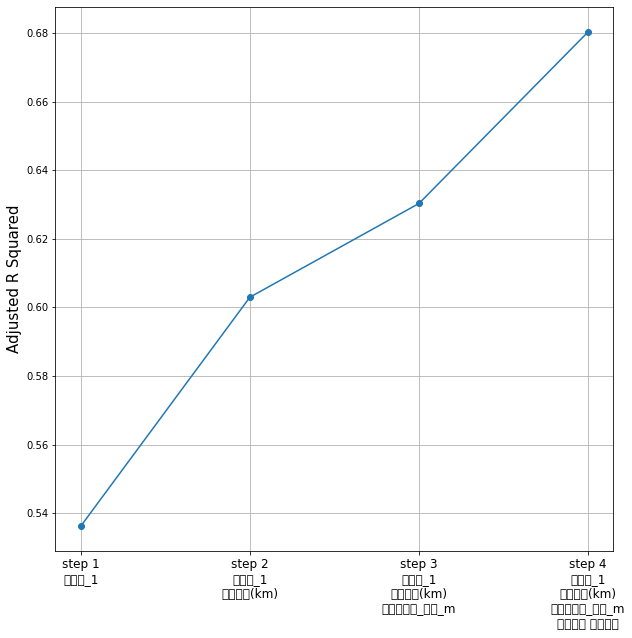

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:14


selected_variables: ['경사도_1', '하천거리(km)', '유도울타리_연장_m', '주변동물 출현빈도']
                            OLS Regression Results                            
Dep. Variable:                일평균이용빈도   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     12.17
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           7.48e-05
Time:                        12:50:26   Log-Likelihood:                -2.2558
No. Observations:                  22   AIC:                             14.51
Df Residuals:                      17   BIC:                             19.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_

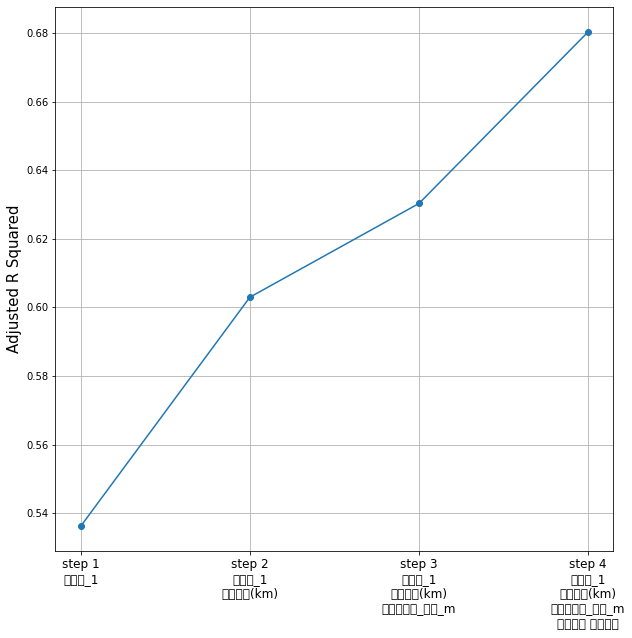

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:14


selected_variables: ['경사도_1', '하천거리(km)', '높이(m)']
                            OLS Regression Results                            
Dep. Variable:                일평균이용빈도   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     13.02
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           9.24e-05
Time:                        12:50:30   Log-Likelihood:                -4.4351
No. Observations:                  22   AIC:                             16.87
Df Residuals:                      18   BIC:                             21.23
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_

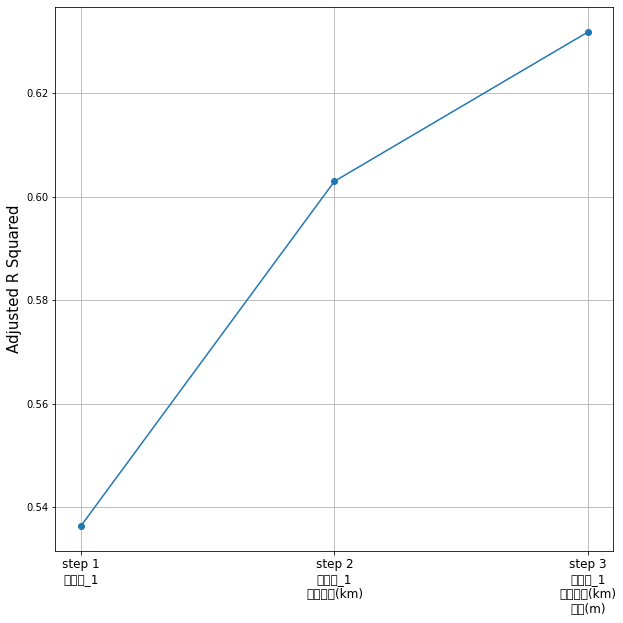

In [ ]:
# 선택된 변수 리스트
selected_variable_list = []
selected_variable_model_list = []

for i in range(8):
  selected_variables, selected_variable_model= step_selection(df_60_list[i], df_60_list[i].drop('일평균이용빈도', axis=1), df_60_list[i]['일평균이용빈도'], df_400_list[i])
  selected_variable_list.append(selected_variables)
  selected_variable_model_list.append(selected_variable_model)

# 예측
- 일평균이용빈도 값이 없던 데이터프레임들(df_400_list)에 대해 일평균이용빈도 값 예측

In [ ]:
# for i in range(len(df_60_list)):
#   print((df_60_list[i][selected_variable_list[i]]).shape) # 학습 데이터
#   print((df_400_list[i][selected_variable_list[i]]).shape) # 테스트 데이터
#   print(selected_variable_list[i])
#   print(selected_variable_model_list[i].summary())

In [ ]:
pred_df_list = []

for i, model in enumerate(selected_variable_model_list):
  print(model)
  pred_freq =  model.predict(sm.add_constant(df_400_list[i][selected_variable_list[i]], has_constant= "add")) # 상수항(=1) 추가 후 predict
  print('예측:', pred_freq)
  pred_df_list.append(pd.DataFrame({'예측된 일평균이용빈도': pred_freq}))
  # print('직접 예측:', np.dot(sm.add_constant(df_400_list[i][selected_variable_list[i]], has_constant= "add"), model.params))

예측: 0      0.270717
1      2.845836
2      3.536157
3      1.344921
4      0.779249
         ...   
295    1.585262
296    2.586207
297    2.462394
298    1.523826
299    3.807847
Length: 262, dtype: float64
예측: 0      0.851805
1      0.851805
2      0.851805
3      0.640446
4      0.290047
         ...   
192    0.290047
193    1.053146
194    0.290047
195    2.208618
196    0.851805
Length: 175, dtype: float64
예측: 0      1.603308
1      4.067348
2      2.482875
3      8.133669
4     -1.398559
         ...   
295    4.067542
296    4.080228
297    4.061216
298    2.161223
299    3.162772
Length: 262, dtype: float64
예측: 0      1.294640
1      5.546760
2      7.828694
3      7.746615
4     -0.380103
         ...   
295    5.117072
296    4.945204
297    4.989650
298    4.110417
299    3.282625
Length: 262, dtype: float64
예측: 0       1.791601
1       4.053942
2       7.207052
3      10.705750
4       2.170266
         ...    
295     4.200938
296     4.016237
297     4.058326
298     2.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# 기존 데이터 셋에 예측한 값 추가
for i, pred_df in enumerate(pred_df_list):
  df_400_list[i].loc[:, '일평균이용빈도'] = pred_df['예측된 일평균이용빈도']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


# Condition No. 확인
- 예측한 데이터에 대한 조건수를 확인

In [ ]:
# Condition Number(조건 수) 확인
minmax_cond = []
# standard_cond = []
for i, df in enumerate(df_400_list):
  minmax_cond.append(np.linalg.cond(df[selected_variable_list[i]]))
  # standard_cond.append(np.linalg.cond(df[selected_variable_list[i]]))

print(minmax_cond)
# print(standard_cond)

[7.087051230440917, 133.42786548152816, 10.503107595058058, 4.644898116303345, 4.462423498207528, 2.529347295896316, 2.529347295896316, 17.5173646361878]


In [ ]:
print(minmax_cond)
print(standard_cond)

[7.087051230440917, 133.42786548152816, 10.503107595058058, 4.644898116303345, 4.462423498207528, 2.529347295896316, 2.529347295896316, 17.5173646361878]
[8.374412885143473, 133.42786548152816, 14.439905673823603, 8.284167693165672, 7.878247402693087, 6.339071054109577, 6.339071054109577, 17.216704393274203]


# 데이터셋 병합 및 저장

In [ ]:
full_df_list = []
for i in range(len(df_400_list)):
  full_df = pd.concat([df_60_list[i], df_400_list[i]], axis=0)
  full_df.reset_index(drop=True, inplace=True)
  full_df_list.append(full_df)

In [ ]:
df_name_list = ['df_overpass_mean', 'df_tunnel_mean', 'df_overpass_knn1', 'df_overpass_knn3', 'df_overpass_knn5', 'df_tunnel_knn1', 'df_tunnel_knn3', 'df_tunnel_knn5']
for i, full_df in enumerate(full_df_list):
  full_df.to_csv('/content/drive/MyDrive/데청캠2022/데청캠 - 프로젝트/' + df_name_list[i] + '.csv', index=False, encoding='cp949')